<a href="https://colab.research.google.com/github/uldkh/colab_projects/blob/main/3_NLP_BOW%2C_determination_of_the_author_of_the_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy2
import re

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils

import os, os.path
import gc

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unrar x "/content/drive/My Drive/DataBases/Texts"

In [ ]:
def get_normal_text_form(text):

  for word in set(text.split()):
    morph = pymorphy2.MorphAnalyzer()
    p = morph.parse(word)[0]
    normal_text.append(p.normal_form)
  normal_text = "".join(normal_text)
  
  return normal_text

In [ ]:
def read_text(filename):
  exc_punctuation = "'\ufeff\xa0!#$%&()*+,-./:;<=>0123456789?@[\\]^_«»`{|}~\t\n"
  f = open(filename, "r")
  text = f.read()
  trans_table = str.maketrans(exc_punctuation, " " * len(exc_punctuation))
  text = text.translate(trans_table)
  text = re.sub(" +", " ", text)
  f.close()
  return text

In [ ]:
class_names = ["Булгаков", "Клиффорд", "Фрай", "Генри", "Брэдберри", "Стругацкие"]
n_classes = len(class_names)

In [ ]:
train_text = []
test_text = []
count = 0
dir = "/content/Texts"

for i in class_names:
  for j in os.listdir(dir):
    if i in j:
      if "Обучающая" in j:
        train_text.append(read_text(dir + "/" + j))
        count += 1
      elif "Тестовая" in j:
        test_text.append(read_text(dir + "/" + j))
        count += 1

print(len(os.listdir(dir)) == count)

True


In [ ]:
(len(train_text), len(train_text[2])), (len(test_text), len(test_text[2]))

((6, 3548504), (6, 1223005))

In [ ]:
def get_set_from_indexes(word_indexes, x_len, step):

  sample = []
  words_len = len(word_indexes)
  index = 0

  while (index + x_len <= words_len):
    sample.append(word_indexes[index: index + x_len])
    index += step
  
  return sample

In [ ]:
def create_sets_multi_classes(word_indexes, x_len, step):

  n_classes = len(word_indexes)
  class_samples = []

  for i in word_indexes:
    class_samples.append(get_set_from_indexes(i, x_len, step))
  
  x_samples = []
  y_samples = []

  for i in range(n_classes):
    selection = class_samples[i]
    for j in range(len(selection)):
      x_samples.append(selection[j])
      y_samples.append(utils.to_categorical(i, n_classes))
  
  x_samples = np.array(x_samples)
  y_samples = np.array(y_samples)

  return x_samples, y_samples

In [ ]:
def create_data(train, test, max_words_count, x_len, step):
 
  tokenizer = Tokenizer(num_words=max_words_count, oov_token="unknown")
  tokenizer.fit_on_texts(train_text)
  print(len(tokenizer.word_index.items()))

  train_word_indexes = tokenizer.texts_to_sequences(train_text)
  test_word_indexes = tokenizer.texts_to_sequences(test_text)

  X_train, y_train = create_sets_multi_classes(train_word_indexes, x_len, step)
  X_test, y_test = create_sets_multi_classes(test_word_indexes, x_len, step)
  print(X_train.shape, y_train.shape)
  print(X_test.shape, y_test.shape)
  print(tokenizer.sequences_to_texts([X_train[0][step: step + 20]]))
  print(tokenizer.sequences_to_texts([X_train[1][0: 20]]))

  X_train_bow = tokenizer.sequences_to_matrix(X_train.tolist(), mode="binary")
  X_test_bow = tokenizer.sequences_to_matrix(X_test.tolist(), mode="binary")
  print(X_train_bow.shape, X_test_bow.shape)

  return X_train_bow, X_test_bow, X_train, y_train, y_test, train_word_indexes, test_word_indexes, tokenizer

In [ ]:
def get_history_plot(history):

  plt.plot(history.history["accuracy"], label="train accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend()
  plt.show()

In [ ]:
def create_test_multi_classes(word_indexes, x_len, step):

  n_classes = len(word_indexes)
  x_test_words = []
  x_test_bow = []

  for i in word_indexes:
    sample = get_set_from_indexes(i, x_len, step)
    x_test_words.append(sample)
    x_test_bow.append(tokenizer.sequences_to_matrix(sample, mode="binary"))
  
  x_test_words = np.array(x_test_words)
  x_test_bow = np.array(x_test_bow)
  
  return x_test_words, x_test_bow

In [ ]:
def recognize_multi_class(model, x_test):

  total_sum_rec = 0

  for i in range(n_classes):
    is_recognized = "Wrong predict"
    current_predict = model.predict(x_test[i])
    current_out = np.argmax(current_predict, axis=1)

    evaluate = []

    for j in range(n_classes):
      evaluate.append(round(len(current_out[current_out == j]) / len(x_test[i]), 2))

    total_sum_rec += len(current_out[current_out == i])
    recognized_class = np.argmax(evaluate)

    if (recognized_class == i):
      is_recognized = "Right predict"
    print(f"Right class - {class_names[i]}, model prediction for this class {100 * evaluate[i]}%, model prediction {class_names[recognized_class]} {100 * evaluate[recognized_class]}% - {is_recognized}")
    print("---" * 50)

  sum = 0
  for i in range(n_classes):
    sum += len(x_test[i])
  print(f"Total predict - {total_sum_rec/sum}")

In [ ]:
max_words_count = 15000
x_len = 5000
step = 100

X_train_bow, X_test_bow, _, y_train, y_test, train_word_indexes, test_word_indexes, tokenizer = create_data(max_words_count, x_len, step)

138496
(18221, 5000) (18221, 6)
(6779, 5000) (6779, 6)
['unknown как стрела и молодые unknown не заметили как в unknown unknown наступил белый мохнатый unknown о unknown дед наш']
['unknown как стрела и молодые unknown не заметили как в unknown unknown наступил белый мохнатый unknown о unknown дед наш']
(18221, 15000) (6779, 15000)


In [ ]:
print("Train text stats:")
print("---" * 14)

symbols_train_count = 0
words_train_count = 0

for i in range(n_classes):
  print(f"{class_names[i]}: {' ' * (10 - len(class_names[i]))} {len(train_text[i])} symbols, {len(train_word_indexes[i])} words")
  symbols_train_count += len(train_text[i])
  words_train_count += len(train_word_indexes[i])
print("---" * 14)
print(f"Total symbols: {symbols_train_count}, Total words: {words_train_count}")
print("***" * 14)
print()

print("Test text stats:")
print("---" * 14)

symbols_test_count = 0
words_test_count = 0

for i in range(n_classes):
  print(f"{class_names[i]}: {' ' * (10 - len(class_names[i]))} {len(test_text[i])} symbols, {len(test_word_indexes[i])} words")
  symbols_test_count += len(test_text[i])
  words_test_count += len(test_word_indexes[i])
print("---" * 14)
print(f"Total symbols: {symbols_test_count}, Total words: {words_test_count}")

Train text stats:
------------------------------------------
Булгаков:    1675925 symbols, 267281 words
Клиффорд:    1530003 symbols, 261934 words
Фрай:        3548504 symbols, 599084 words
Генри:       1010850 symbols, 166214 words
Брэдберри:   1318823 symbols, 227317 words
Стругацкие:  1953719 symbols, 329971 words
------------------------------------------
Total symbols: 11037824, Total words: 1851801
******************************************

Test text stats:
------------------------------------------
Булгаков:    834143 symbols, 138124 words
Клиффорд:    303311 symbols, 54261 words
Фрай:        1223005 symbols, 206088 words
Генри:       336372 symbols, 55425 words
Брэдберри:   825888 symbols, 140374 words
Стругацкие:  674172 symbols, 113322 words
------------------------------------------
Total symbols: 4196891, Total words: 707594


In [ ]:
total_count = (words_train_count, words_test_count)
dividers = []
for i in total_count:
  divider = []
  for j in range(1, 10000):
    if i % j == 0:
      divider.append(j)
  dividers.append(divider)
  
print(set(dividers[0]) & set(dividers[1]))

for i in range(70, 400):
  if X_train_bow.shape[0] % i == 0:
    print(i)

{1}
133
137


In [ ]:
model = Sequential()

model.add(Dense(100, input_dim=max_words_count, activation="elu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(50, activation="elu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(6, activation="softmax"))
model.compile(optimizer=Adam(0.001), loss="categorical_crossentropy", metrics="accuracy")

history = model.fit(X_train_bow, y_train, epochs=15, batch_size=133, validation_data=(X_test_bow, y_test))

Epoch 1/15
137/137 [==============================] - 4s 16ms/step - loss: 0.1006 - accuracy: 0.9788 - val_loss: 0.1992 - val_accuracy: 0.9400
Epoch 2/15
137/137 [==============================] - 2s 13ms/step - loss: 0.0113 - accuracy: 0.9997 - val_loss: 0.1494 - val_accuracy: 0.9720
Epoch 3/15
137/137 [==============================] - 2s 13ms/step - loss: 0.0059 - accuracy: 0.9999 - val_loss: 0.1500 - val_accuracy: 0.9696
Epoch 4/15
137/137 [==============================] - 2s 15ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1497 - val_accuracy: 0.9665
Epoch 5/15
137/137 [==============================] - 2s 13ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1615 - val_accuracy: 0.9615
Epoch 6/15
137/137 [==============================] - 2s 13ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.1406 - val_accuracy: 0.9661
Epoch 7/15
137/137 [==============================] - 2s 13ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1315 - val_accuracy: 0.9680

In [ ]:
gc.collect()

884

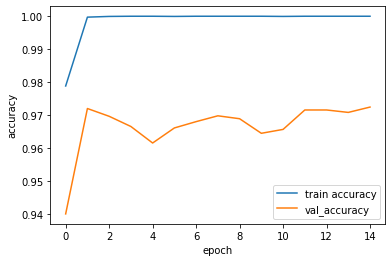

In [ ]:
get_history_plot(history)

In [ ]:
_, x_test_bow = create_test_multi_classes(test_word_indexes, x_len, step)

In [ ]:
recognize_multi_class(model, x_test_bow)

Right class - Булгаков, model prediction for this class 98.0%, model prediction Булгаков 98.0% - Right predict
------------------------------------------------------------------------------------------------------------------------------------------------------
Right class - Клиффорд, model prediction for this class 100.0%, model prediction Клиффорд 100.0% - Right predict
------------------------------------------------------------------------------------------------------------------------------------------------------
Right class - Фрай, model prediction for this class 92.0%, model prediction Фрай 92.0% - Right predict
------------------------------------------------------------------------------------------------------------------------------------------------------
Right class - Генри, model prediction for this class 100.0%, model prediction Генри 100.0% - Right predict
-----------------------------------------------------------------------------------------------------------------